<a href="https://colab.research.google.com/github/csaybar/Carvana_kaggle/blob/master/carvana_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carvana Image Masking Challenge (kaggle) with tensorflow 2.0


<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/csaybar/Carvana_kaggle/blob/master/carvana_kaggle.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/csaybar/Carvana_kaggle/blob/master/carvana_kaggle.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

## Description:
As with any big purchase, full information and transparency are key. While most everyone describes buying a used car as frustrating, it’s just as annoying to sell one, especially online. Shoppers want to know everything about the car but they must rely on often blurry pictures and little information, keeping used car sales a largely inefficient, local industry.

Carvana, a successful online used car startup, has seen opportunity to build long term trust with consumers and streamline the online buying process.

An interesting part of their innovation is a custom rotating photo studio that automatically captures and processes 16 standard images of each vehicle in their inventory. While Carvana takes high quality photos, bright reflections and cars with similar colors as the background cause automation errors, which requires a skilled photo editor to change.
<center>
<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/carvana_graphics.png" /> 
 </center>

In this competition, you’re challenged to develop an algorithm that automatically removes the photo studio background. This will allow Carvana to superimpose cars on a variety of backgrounds. You’ll be analyzing a dataset of photos, covering different vehicles with a wide variety of year, make, and model combinations.

The dataset of this competition contains a large number of car images, with each car taken from different angles. In addition, for each car image, we have an associated manually cutout mask; our task will be to automatically create these cutout masks for unseen data. 



## My Workflow 

1. Visualize data/perform some exploratory data analysis
2. Set up data pipeline and preprocessing (ImageDataGenerator)
3. Build model
4. Train model
5. Evaluate model
6. Repeat


In [0]:
!pip install kaggle
!pip install tensorflow==2.0.0-alpha0

In [0]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing import image as img

mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)


In [0]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

Saving kaggle.json to kaggle.json


In [0]:
import kaggle

In [0]:
competition_name = 'carvana-image-masking-challenge'

In [0]:

# Download data from Kaggle and unzip the files of interest. # Downl 
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')

In [0]:
get_data(competition_name)

In [0]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [0]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [0]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [0]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


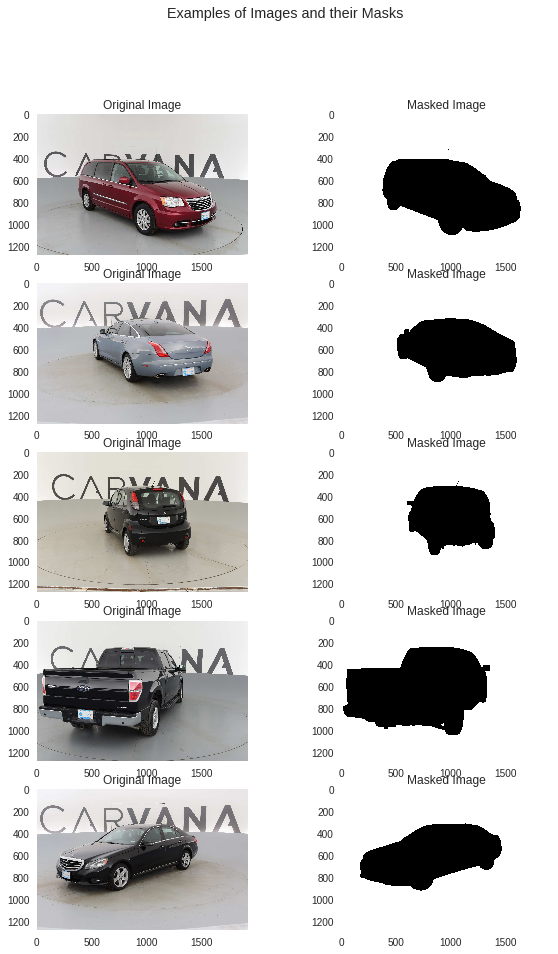

In [0]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [0]:
img_shape = (256, 256, 3)
batch_size = 3
epochs = 5

In [0]:
from tensorflow.keras.preprocessing import image as pretf_img
from tensorflow.keras import layers

In [0]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.io.read_file(fname)
  img = tf.image.decode_jpeg(img_str, channels=3)
  
  label_img_str = tf.io.read_file(label_path)
  # These are gif images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_gif(label_img_str)[0]
  # The label image should only have values of 1 or 0, indicating pixel wise
  # object (car) or not (background). We take the first channel only. 
  label_img = label_img[:, :, 0]
  print(tf.shape(label_img))
  label_img = tf.expand_dims(label_img, axis=-1)
  print(tf.shape(label_img))
  return img, label_img

In [0]:
def get_baseline_dataset(filenames, 
                         labels,
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if shuffle:
    dataset = dataset.shuffle(num_x)
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [0]:
train_ds = get_baseline_dataset(x_train_filenames,y_train_filenames,5,32,True)
val_ds = get_baseline_dataset(x_val_filenames,y_val_filenames,batch_size=3)

Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape_1:0", shape=(3,), dtype=int32)
Tensor("Shape:0", shape=(2,), dtype=int32)
Tensor("Shape_1:0", shape=(3,), dtype=int32)


In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [0]:
from tensorflow.keras import layers

In [0]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [0]:
from tensorflow.keras import models
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K

model = models.Model(inputs=[inputs], outputs=[outputs])

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

In [0]:
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [0]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

NameError: ignored